In [1]:
# module imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import os

In [2]:
# Find all files in the "Clean Datasets" folder that is csv
files = Path('./Clean Datasets/top_30').glob('*.csv')
# Initiate blank dataframe
df = pd.DataFrame()

# Iterate through all found csvs from clean datasets folder
for file in files:
    # read csv file
    curr_df = pd.read_csv(file)

    # Fix column names to add meaning to the column names
    if os.path.basename(file) == 'country_sea_levels.csv':
        curr_df.rename(columns={'Value': 'Sea Level'}, inplace=True)
    elif os.path.basename(file) == 'climate_disasters_clean.csv':
        curr_df.rename(columns={'TOTAL': 'Total Disasters'}, inplace=True)

    # check if dataframe is empty
    if df.empty:
        # set dataframe to current dataframe
        df = curr_df
    else:
        # merge dataframe on Year bind as inner
        df = df.merge(curr_df, on=['Year', 'Country'], how='inner')

# Find all string columns
column_names = [col for col in df.columns if all(isinstance(val, str) for val in df[col].dropna())]
# Initiate label encoder for string columns
label_encoder = LabelEncoder()

# Iterate each column that is string
for column_name in column_names:
    # Ensure column is in dataframe
    if column_name in df.columns.tolist():
        # Fill na as Unknown
        df[column_name] = df[column_name].fillna('Unknown')
        # Encode column with labels
        df[column_name] = label_encoder.fit_transform(df[column_name]) + 1
        # Cast labels as integer data type
        df[column_name] = df[column_name].astype(int)

# Drop bias columns that is part of the target predictor TOTAL
df.drop(columns=['Drought', 'Extreme temperature', 'Flood', 'Landslide', 'Storm', 'Wildfire'], inplace=True)
# Replace NAs with the mean of the column
df.fillna(df.mean(), inplace=True)
# Drop blank rows
df.dropna(how='all', inplace=True)
# Drop columns with all identical values
df = df.loc[:, (df.nunique(dropna=False) != 1)]
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# describe dataframe
df.describe()

,Year,Country,Total Disasters,Sea Level,Carbon stocks in forests,Forest area,Index of carbon stocks in forests,Index of forest extent,Land area,Share of forest area,...,Inland water bodies: Climate regulating,Mangroves: Climate regulating,Permanent snow and glaciers: Climate regulating,Shrub-covered areas: Climate regulating,"Shrubs and/or herbaceous vegetation, aquatic or regularly flooded: Climate regulating",Sparsely natural vegetated areas: Climate neutral,Terrestrial barren land: Climate neutral,Tree-covered areas: Climate regulating,Woody crops: Climate regulating,Temperature
count,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,7.830000e+02,783.000000,...,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000
mean,2006.000000,14.000000,6.010217,20.649490,7086.710437,106930.159595,106.909863,101.113691,2.873427e+05,34.093267,...,8728.770385,420.969536,1444.040238,38753.358885,5332.795820,22896.458647,12822.811778,110271.135128,4784.297902,0.844341
std,8.371948,7.793859,6.167516,27.326441,12420.362934,186319.186199,17.480469,10.847441,4.114564e+05,17.543604,...,22015.345888,875.394336,3807.985911,58813.436468,15854.602557,58887.922289,32788.028540,205435.994961,6785.109546,0.508004
min,1992.000000,1.000000,0.000000,-56.614776,19.004300,347.300000,76.168056,76.168044,2.756000e+03,4.833307,...,30.513500,0.000000,0.000000,42.569600,0.000000,0.589000,0.000000,419.359300,46.196100,-0.446000
25%,1999.000000,7.000000,2.000000,-1.059465,583.021400,7379.692500,96.672329,95.564400,2.981700e+04,17.322251,...,460.898900,0.000000,0.000000,1325.154000,31.633400,21.104450,3.975950,8686.549600,559.287250,0.489000
50%,2006.000000,14.000000,4.000000,16.309054,1665.456800,19965.500000,99.790294,99.762585,7.708800e+04,33.858818,...,953.969800,47.672900,0.000000,6872.307300,261.050100,508.071900,371.757300,23163.564700,2311.685900,0.802000
75%,2013.000000,21.000000,7.000000,42.872464,8288.176700,96417.290000,112.830317,103.469083,2.973190e+05,49.399566,...,4102.970900,415.826200,488.215300,64537.405100,3109.648200,9196.671900,12647.150000,81986.488750,5460.979000,1.147500
max,2020.000000,27.000000,34.000000,120.204167,58129.141200,815311.600000,171.250377,148.546379,1.638995e+06,69.553288,...,104025.000000,4117.394400,18314.800000,202541.915200,87681.500000,284361.000000,172636.364200,955922.993800,32056.761900,3.691000


In [3]:
# Seed value
seed_value = 42
# Initiate min max scalar
scaler = MinMaxScaler()

# Normalization function
def normalize(dataframe, cols_to_exclude = [], fit=False):
    # If fit and columns to exclude then...
    if fit and cols_to_exclude:
        # Drop columns to exclude
        df2 = dataframe.drop(cols_to_exclude, axis=1)
        # Fit dataframe
        scaler.fit(df2)
    elif fit:
        # fit dataframe if fit is true
        scaler.fit(dataframe)
    elif cols_to_exclude:
        # drop columns to exclude
        df2 = dataframe.drop(cols_to_exclude, axis=1)
        # store excluded columns into a different dataframe
        df3 = dataframe[cols_to_exclude]
        # transform df2 according to fitted scalar
        df2 = pd.DataFrame(scaler.transform(df2), columns=df2.columns)
        # combine both dataframes back together
        return concat([df2.reset_index(drop=True), df3.reset_index(drop=True)], axis=1)
    else:
        # transform dataframe according to fitted scalar
        return pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns).reset_index(drop=True)

# Initialize numpy random seed
np.random.seed(seed_value)
# Drop label from dataframe
x = df.drop(['Total Disasters', 'Year'], axis=1)
# Put label as y variable
y = df['Total Disasters']
# Split train/test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed_value)

# Fill nas with mean
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())

# Create eda dataframes by combining both data and label into one dataframe, but keep to train/test datasets
train_eda_df = x_train.copy()
train_eda_df['Total Disasters'] = y_train
test_cda_df = x_test.copy()
test_cda_df['Total Disasters'] = y_test

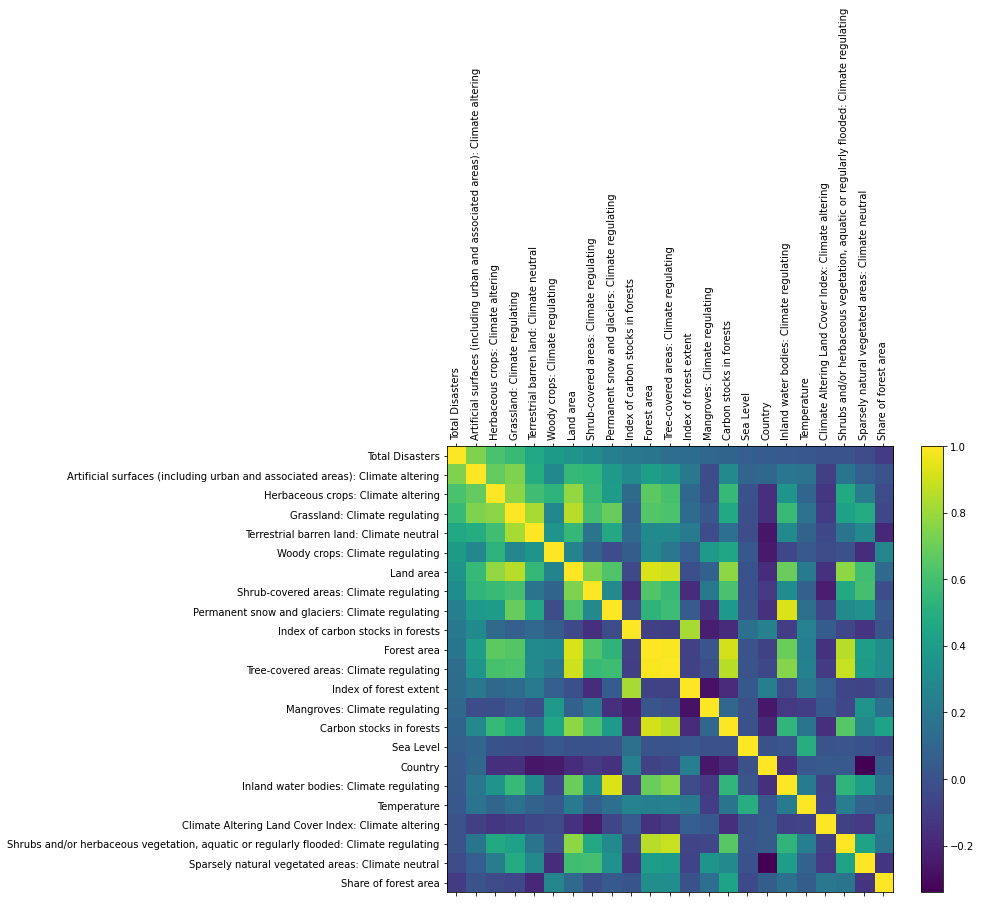

In [4]:
# import visual package matplotlib
import matplotlib.pyplot as plt

# Find top 30 correlated features to the predictor TOTAL and get the column names
corr_cols = train_eda_df.corr().loc[:,['Total Disasters']].dropna().sort_values(by=['Total Disasters'], ascending=False, axis=0).head(31).T.columns.tolist()

# Plot correlation of the top 30 correlated features including TOTAL
plt.figure(figsize=(10, 8))
plt.matshow(train_eda_df.loc[:, corr_cols].corr(), fignum=1)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)

plt.colorbar()
plt.show()

C:\Users\kevin\AppData\Local\Temp\ipykernel_8936\901441390.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


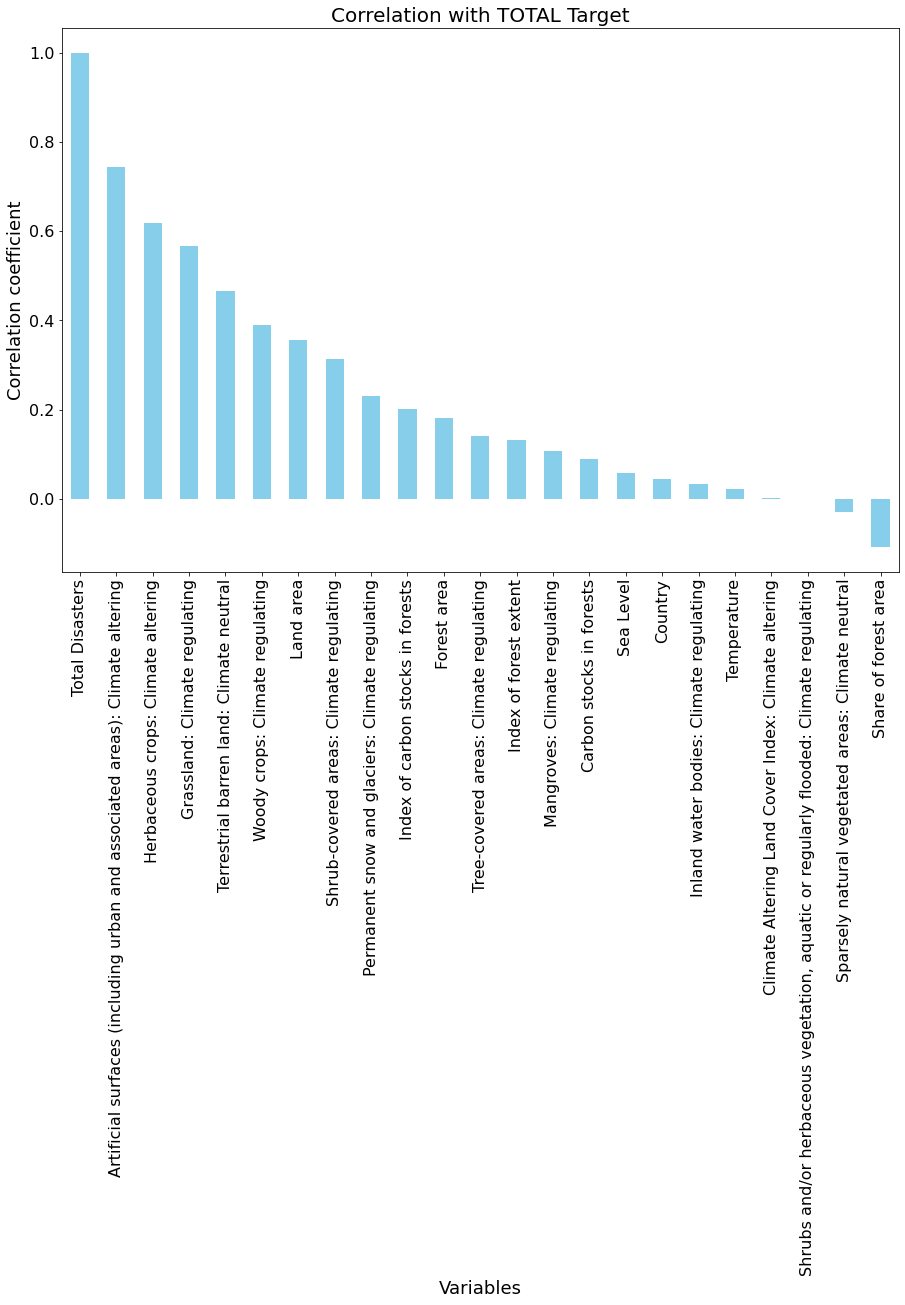

In [5]:
# Target label
target = 'Total Disasters'
# Find best correlated features
best_feats = train_eda_df.corr().sort_values(by=[target], ascending=False, axis=0)[target]

# Display best features as bar graph
plt.rcParams.update({'font.size': 14}) 
plt.figure(figsize=(15, 10))
best_feats.plot(kind='bar', color='skyblue')
plt.title('Correlation with TOTAL Target', fontsize=20)
plt.xlabel('Variables', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('./images/corr_plot.png', dpi=300, bbox_inches='tight')
plt.show()

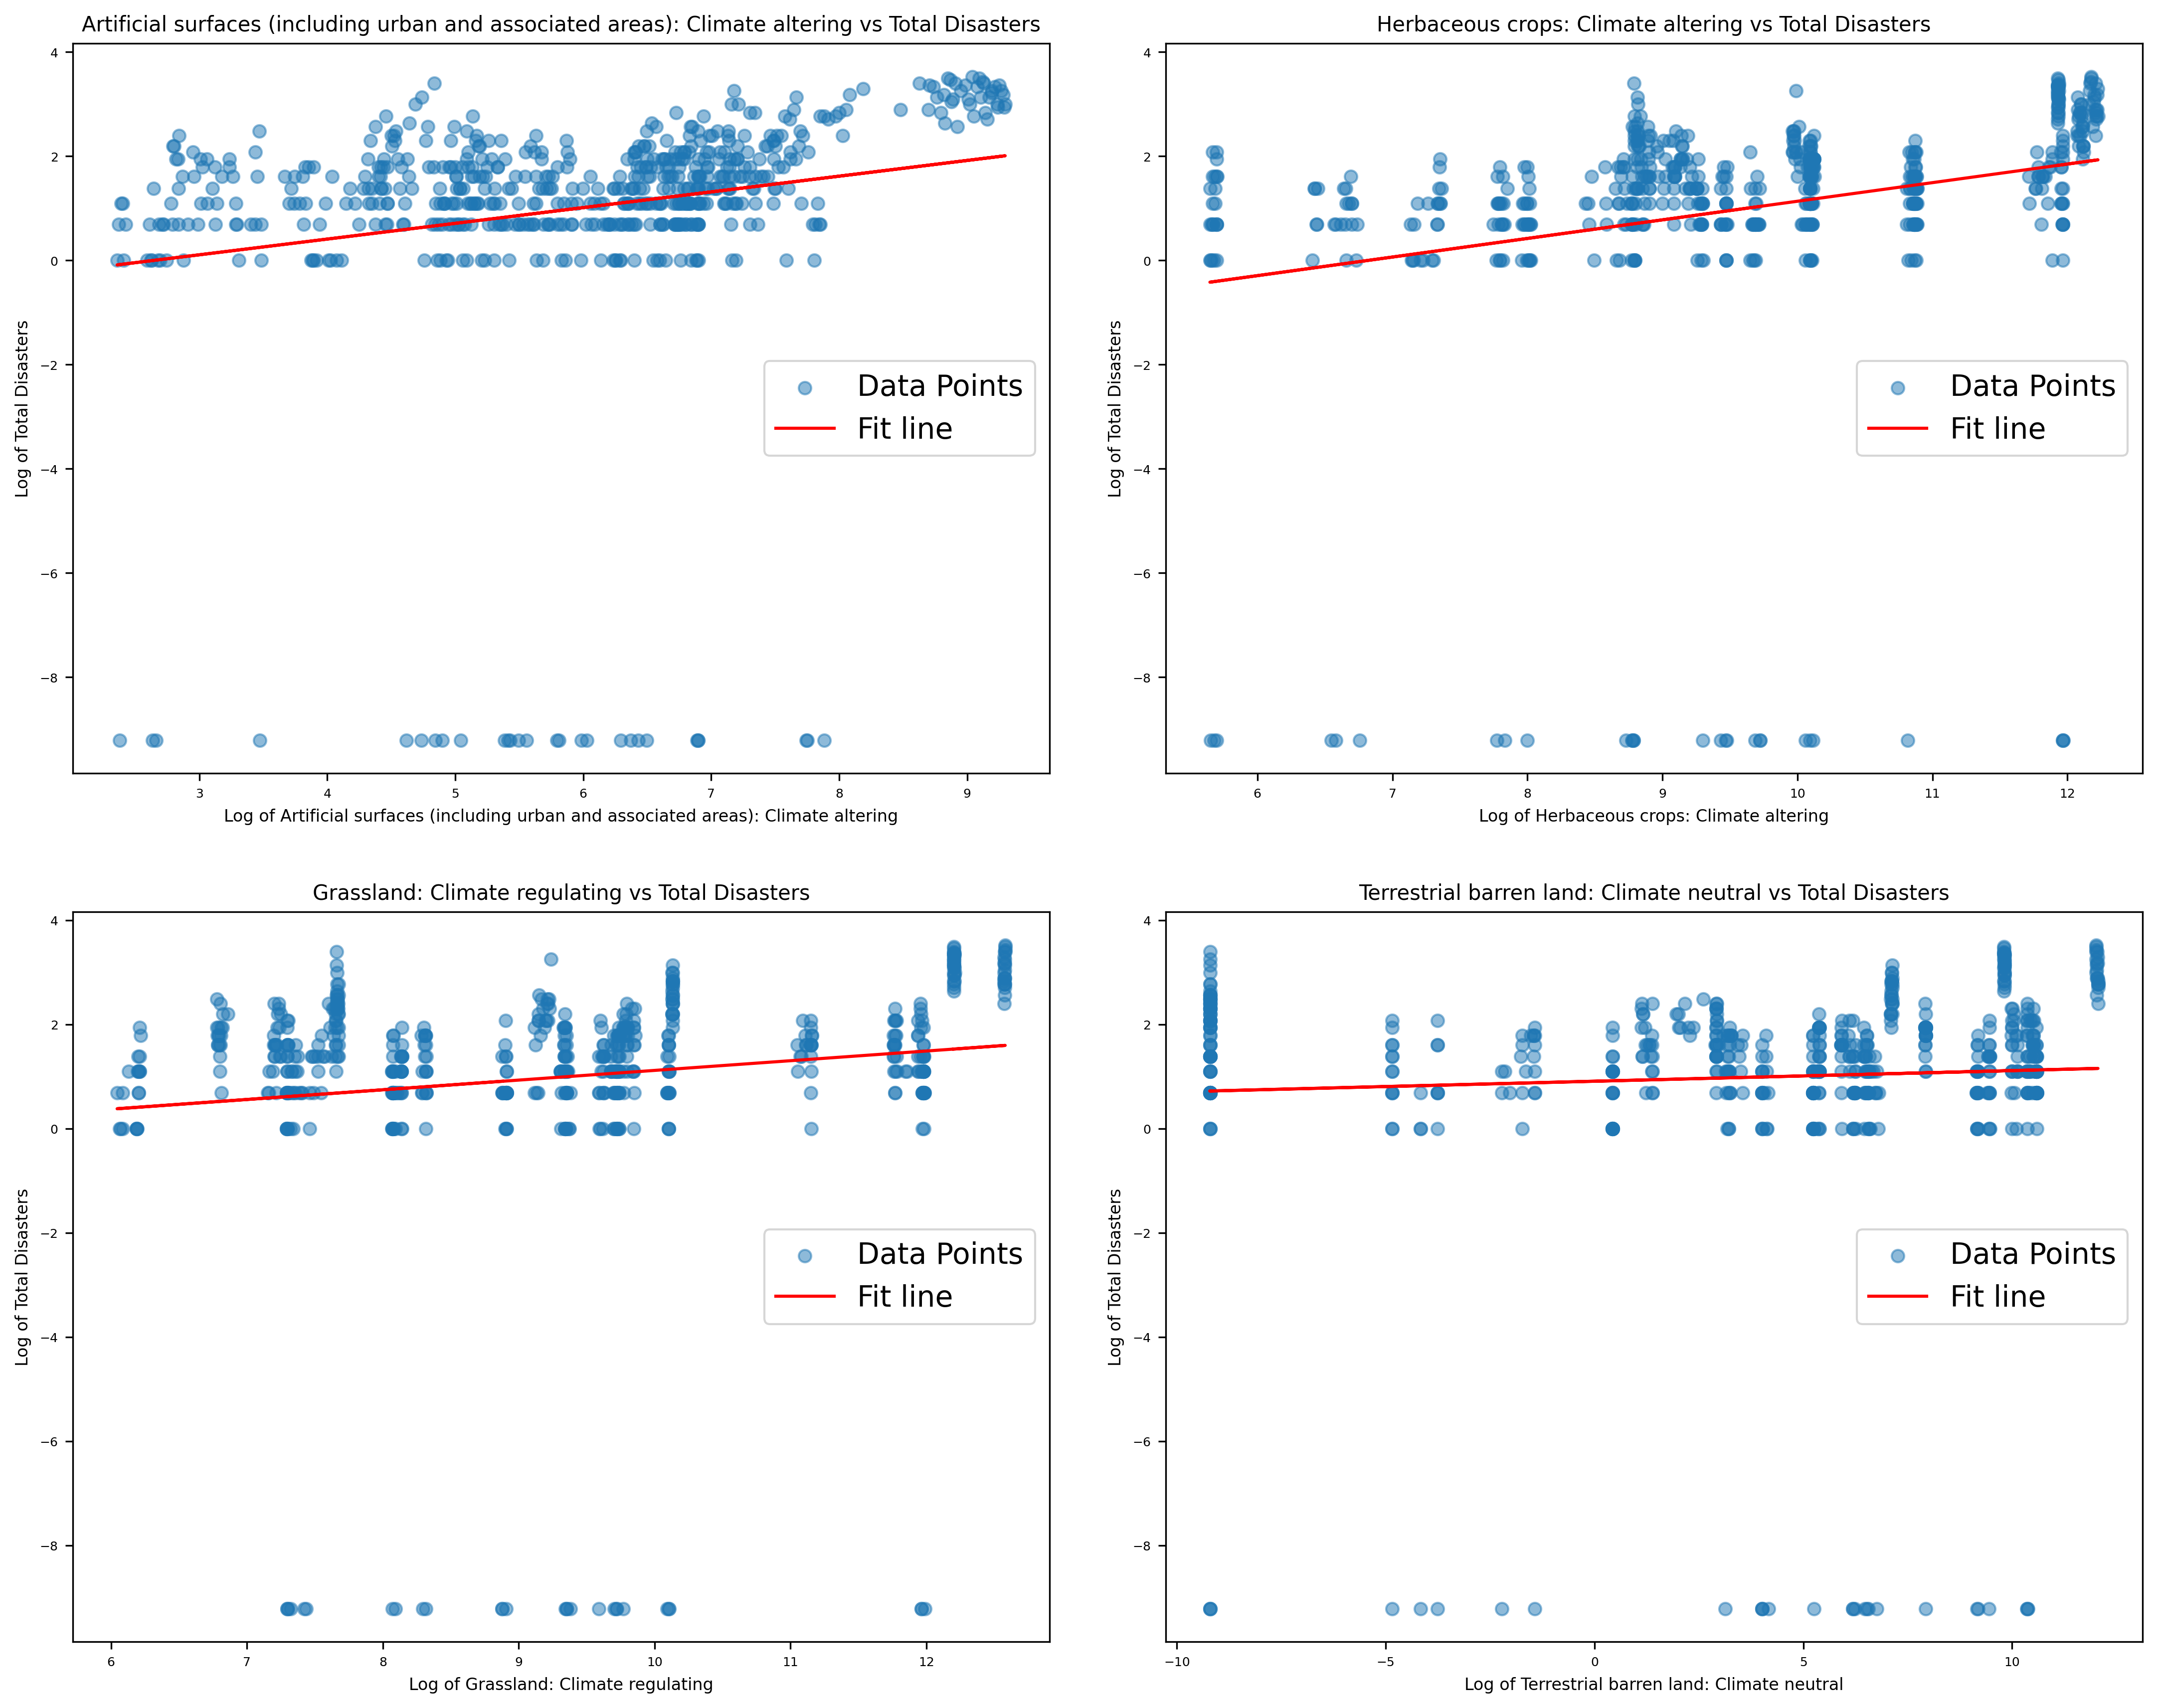

In [6]:
# Define features to plot in relation to predictor
variables = [
    'Artificial surfaces (including urban and associated areas): Climate altering',
    'Herbaceous crops: Climate altering',
    'Grassland: Climate regulating',
    'Terrestrial barren land: Climate neutral'
]
# Define predictor
target = 'Total Disasters'

# copy dataframe that is not label
df_copy = train_eda_df[[col for col in train_eda_df.columns if target not in col or col == target]].copy()
# create plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
axes = axes.flatten()
epsilon = 1e-4
title_fontsize = 10
label_fontsize = 8
tick_labelsize = 6
# transform label with log
df_copy[target] = np.log(df_copy[target] + epsilon)

# Iterate through features
for i, var_x in enumerate(variables):
    # transform feature with log
    df_copy[var_x] = np.log(df_copy[var_x] + epsilon)

    try:
        # Attempt line prediction fit of data
        m, b = np.polyfit(df_copy[var_x], df_copy[target], 1)
        y_hat = m * df_copy[var_x] + b
    except:
        # If error return y_hat as none
        y_hat = None
        pass

    # Plot scatter graph
    axes[i].scatter(df_copy[var_x], df_copy[target], alpha=0.5, label='Data Points')
    
    if y_hat is not None:
        # Add prediction line if y_hat is defined
        axes[i].plot(df_copy[var_x], y_hat, color='red', label='Fit line')

    # Adjust the title and labels with the new font size
    axes[i].set_title(f'{var_x} vs {target}', fontsize=title_fontsize)
    axes[i].set_xlabel(f'Log of {var_x}', fontsize=label_fontsize)
    axes[i].set_ylabel(f'Log of {target}', fontsize=label_fontsize)
    axes[i].tick_params(axis='both', which='major', labelsize=tick_labelsize)
    axes[i].legend()

# Save graph
plt.tight_layout(pad=2.0)
plt.savefig('./images/eda_graph.png', bbox_inches='tight')

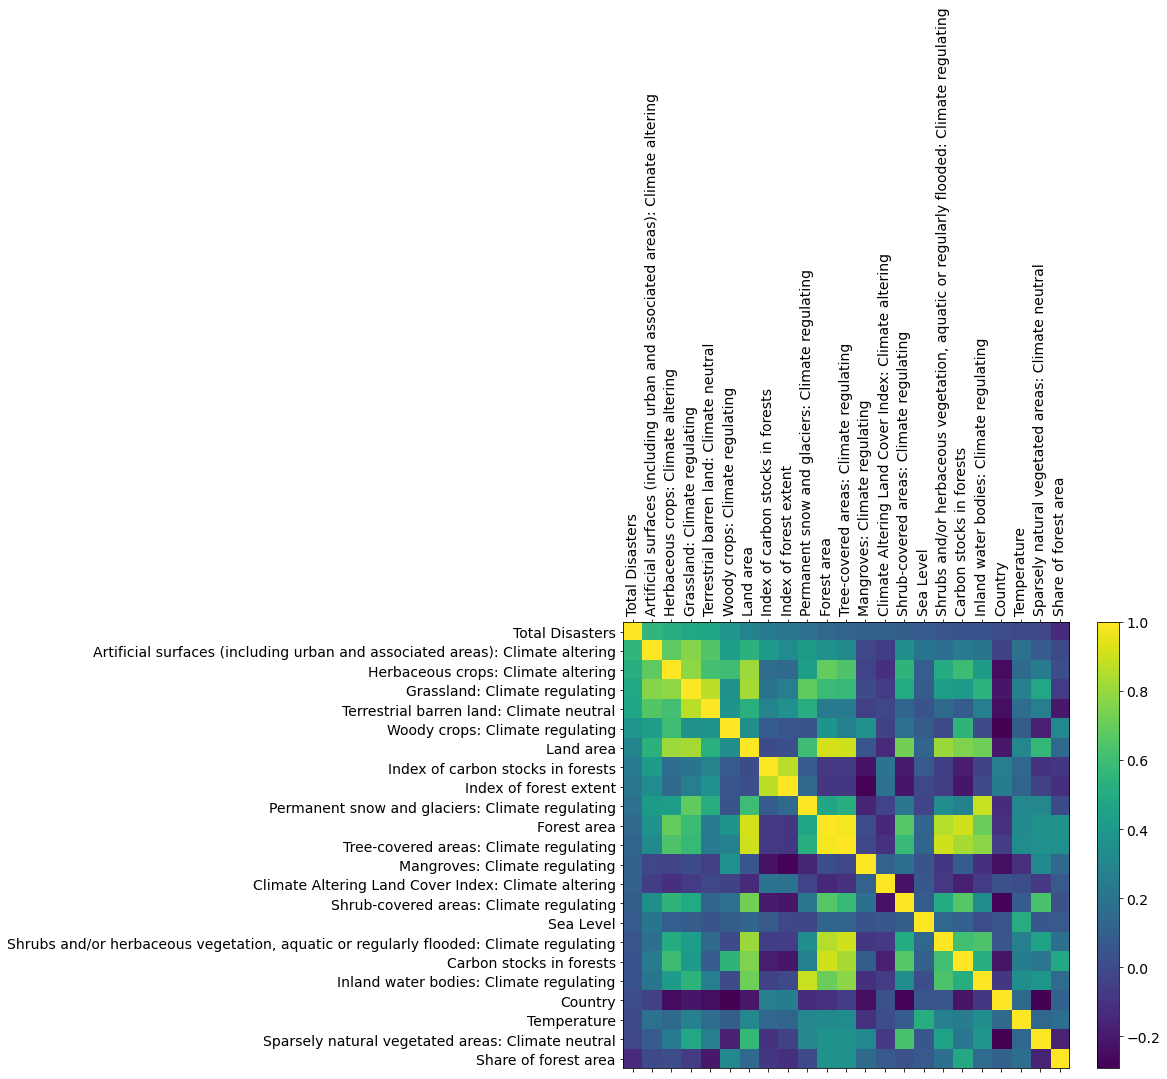

In [7]:
# import visual package matplotlib
import matplotlib.pyplot as plt

# Find top 30 correlated features to the predictor TOTAL and get the column names
corr_cols = test_cda_df.corr().loc[:,['Total Disasters']].dropna().sort_values(by=['Total Disasters'], ascending=False, axis=0).head(31).T.columns.tolist()

# Plot correlation of the top 30 correlated features including TOTAL
plt.figure(figsize=(10, 8))
plt.matshow(test_cda_df.loc[:, corr_cols].corr(), fignum=1)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)

plt.colorbar()
plt.show()

C:\Users\kevin\AppData\Local\Temp\ipykernel_8936\1167221584.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


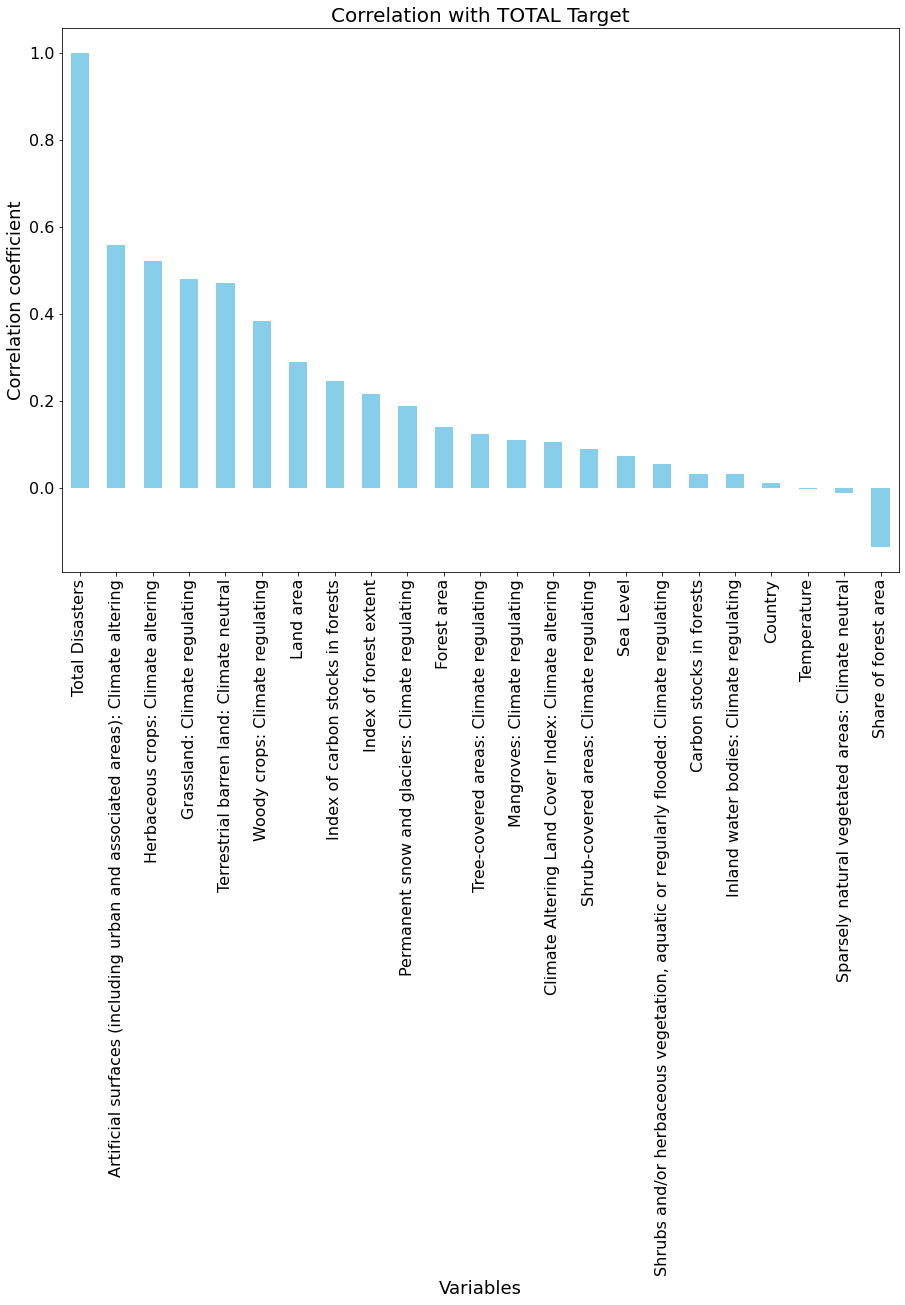

In [8]:
# Target label
target = 'Total Disasters'
# Find best correlated features
best_feats = test_cda_df.corr().sort_values(by=[target], ascending=False, axis=0)[target]

# Display best features as bar graph
plt.rcParams.update({'font.size': 14}) 
plt.figure(figsize=(15, 10))
best_feats.plot(kind='bar', color='skyblue')
plt.title('Correlation with TOTAL Target', fontsize=20)
plt.xlabel('Variables', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('./images/corr_plot.png', dpi=300, bbox_inches='tight')
plt.show()

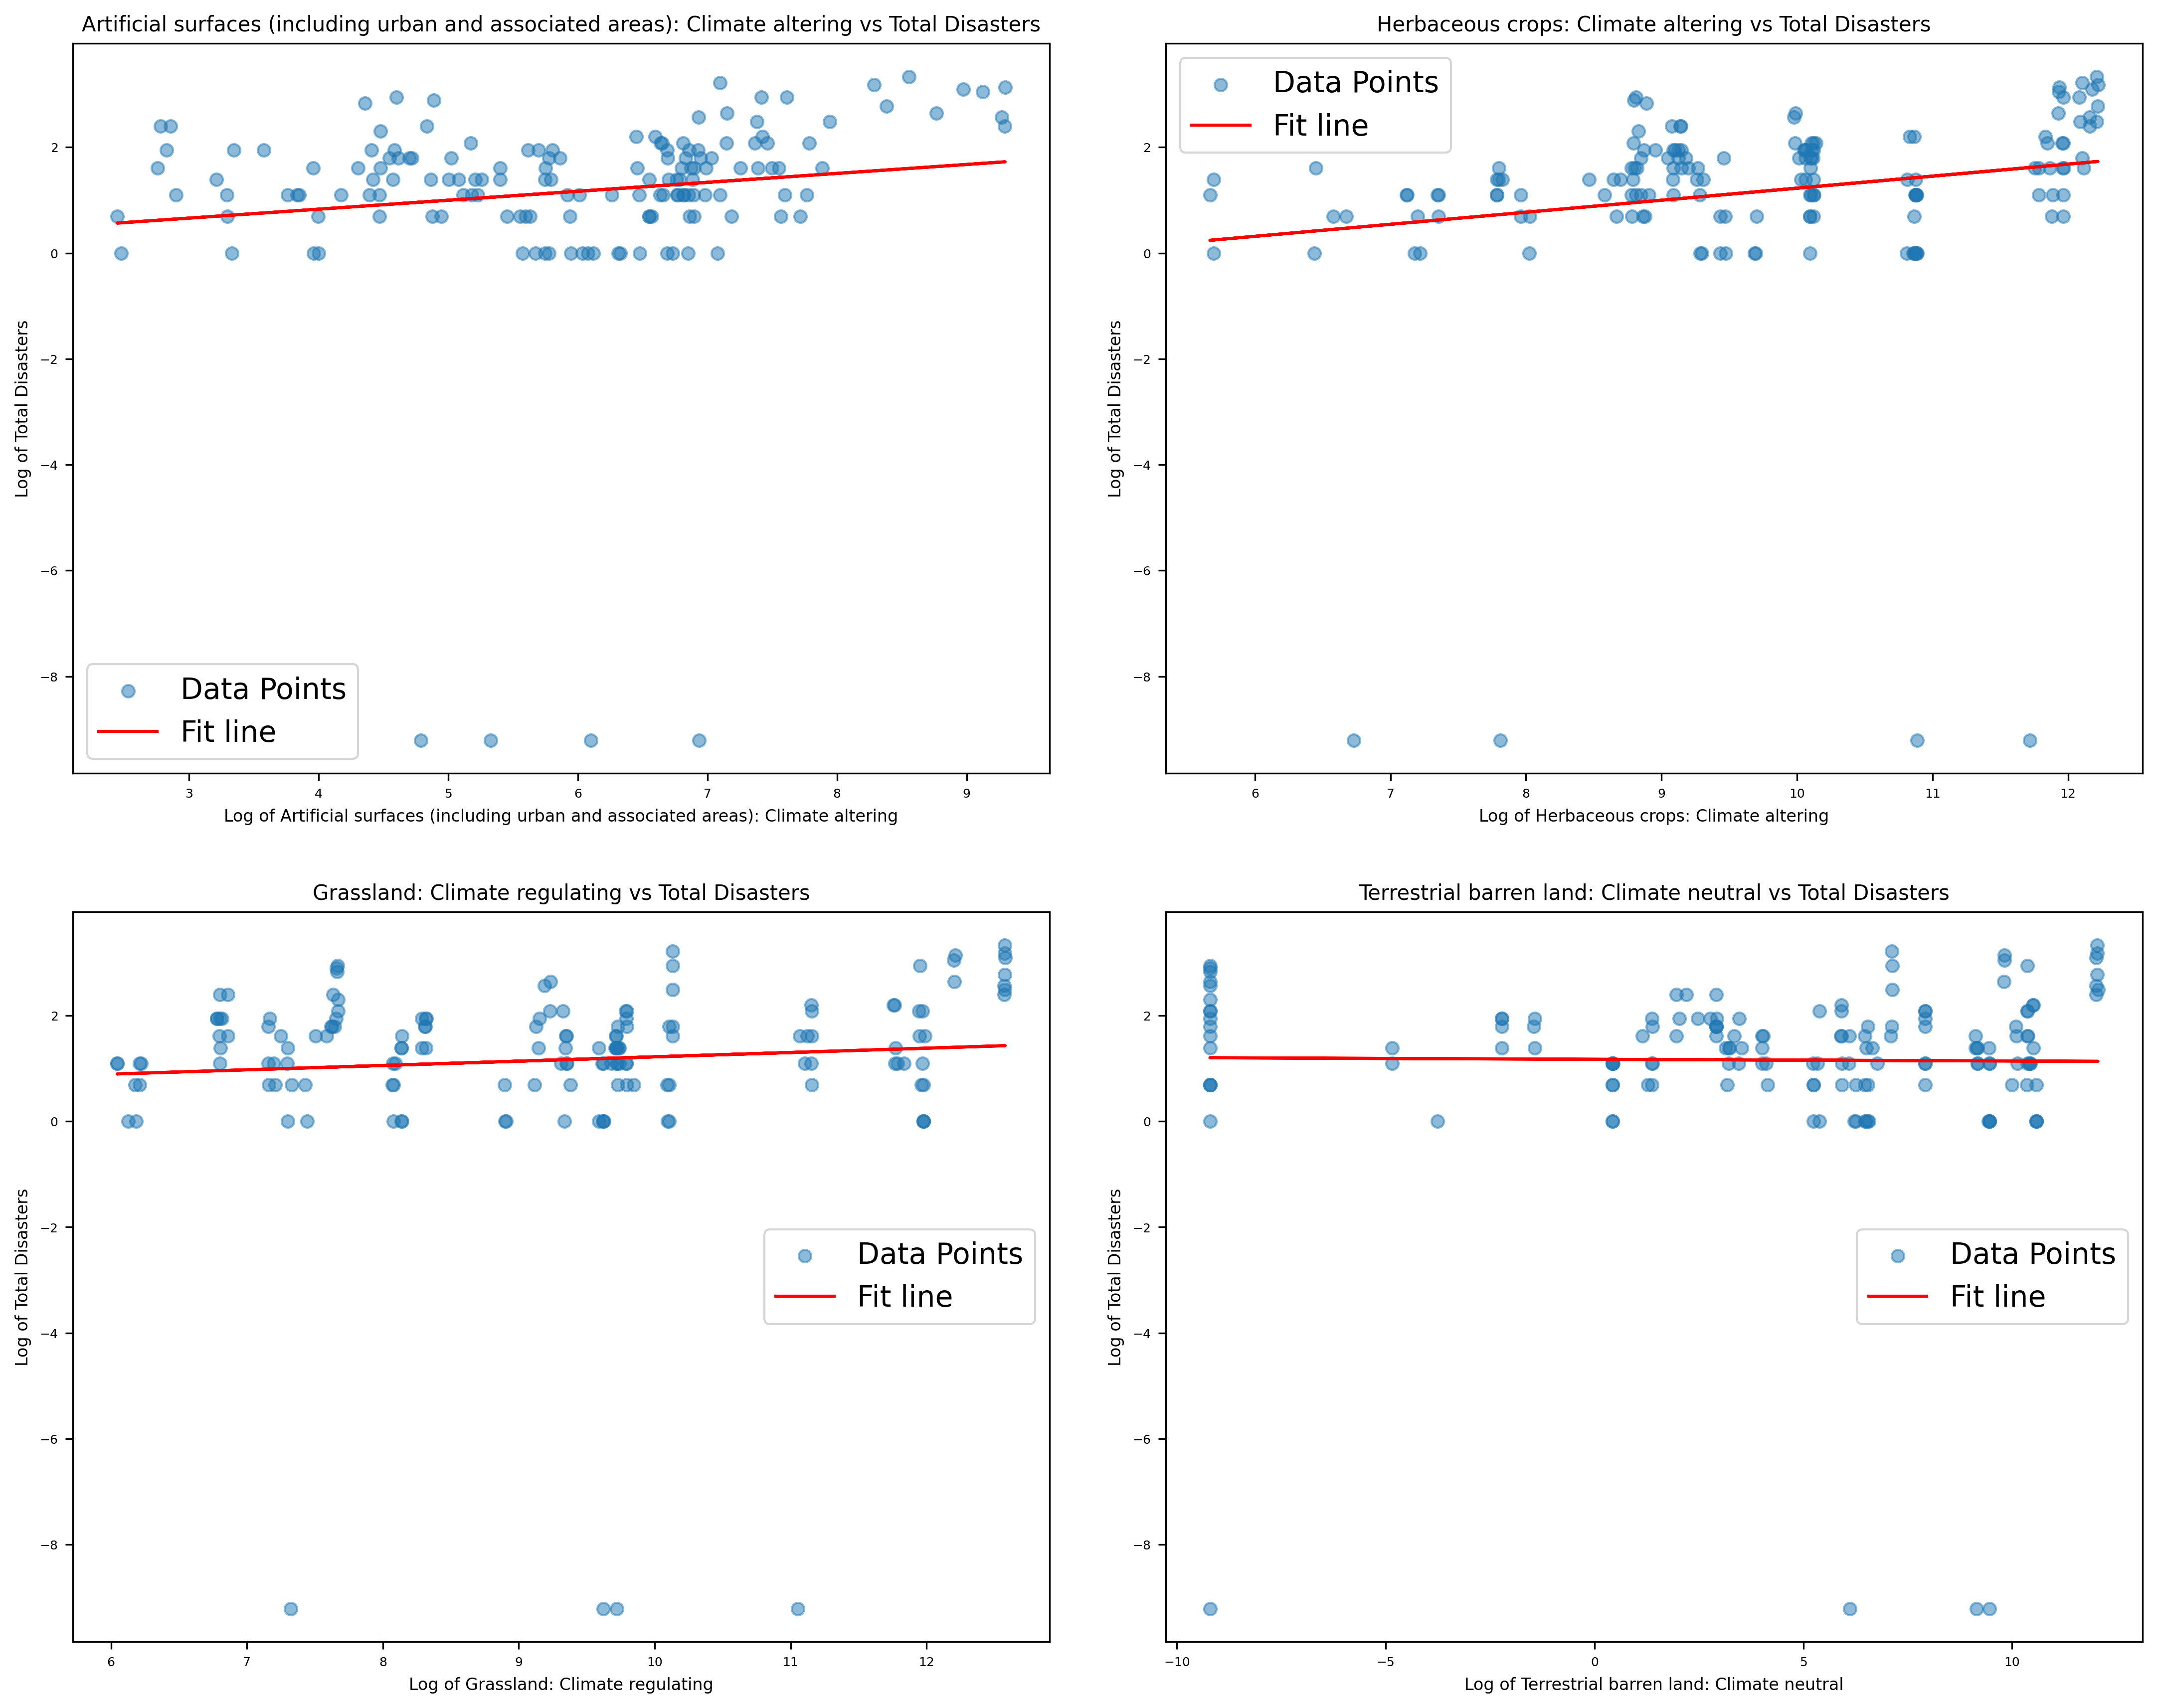

In [9]:
# Define features to plot in relation to predictor
variables = [
    'Artificial surfaces (including urban and associated areas): Climate altering',
    'Herbaceous crops: Climate altering',
    'Grassland: Climate regulating',
    'Terrestrial barren land: Climate neutral'
]
# Define predictor
target = 'Total Disasters'

# copy dataframe that is not label
df_copy = test_cda_df[[col for col in train_eda_df.columns if target not in col or col == target]].copy()
# create plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
axes = axes.flatten()
epsilon = 1e-4
title_fontsize = 10
label_fontsize = 8
tick_labelsize = 6
# transform label with log
df_copy[target] = np.log(df_copy[target] + epsilon)

# Iterate through features
for i, var_x in enumerate(variables):
    # transform feature with log
    df_copy[var_x] = np.log(df_copy[var_x] + epsilon)

    try:
        # Attempt line prediction fit of data
        m, b = np.polyfit(df_copy[var_x], df_copy[target], 1)
        y_hat = m * df_copy[var_x] + b
    except:
        # If error return y_hat as none
        y_hat = None
        pass

    # Plot scatter graph
    axes[i].scatter(df_copy[var_x], df_copy[target], alpha=0.5, label='Data Points')
    
    if y_hat is not None:
        # Add prediction line if y_hat is defined
        axes[i].plot(df_copy[var_x], y_hat, color='red', label='Fit line')

    # Adjust the title and labels with the new font size
    axes[i].set_title(f'{var_x} vs {target}', fontsize=title_fontsize)
    axes[i].set_xlabel(f'Log of {var_x}', fontsize=label_fontsize)
    axes[i].set_ylabel(f'Log of {target}', fontsize=label_fontsize)
    axes[i].tick_params(axis='both', which='major', labelsize=tick_labelsize)
    axes[i].legend()

# Save graph
plt.tight_layout(pad=2.0)
plt.savefig('./images/cda_graph.png', bbox_inches='tight')

In [10]:
# Normalize and fit to training dataset
# normalize(x_train, fit=True)
# x_train = normalize(x_train)
# x_test = normalize(x_test)

In [11]:
from sklearn.linear_model import Ridge
from sklearn import metrics

# Ridge Regression with L2 Regularization
ridge_reg = Ridge(alpha=1.0, random_state=seed_value)
ridge_reg.fit(x_train, y_train)

# Predict with Ridge Regression
y_test_pred = ridge_reg.predict(x_test)

# Evaluate Ridge Regression
test_r2 = metrics.r2_score(y_test, y_test_pred)
test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print("\nRegression Report (Test Data):")
print(f"Test R-squared: {test_r2:.2f}")
print(f"Test Mean Absolute Error: {test_mae:.2f}")
print(f"Test Root Mean Squared Error: {test_rmse:.2f}")


Regression Report (Test Data):
Test R-squared: 0.45
Test Mean Absolute Error: 2.80
Test Root Mean Squared Error: 3.97
